# RDKit Heatmaps
This module allows to draw heatmaps to molecular depictions, analogous to the function `rdkit.Chem.Draw.rdMolDraw2D.ContourAndDrawGaussians`.  
Contrasting the original implementation, this module offers 2-dimensional Gauss-functions, allowing to stretch the distribution. These 'stretched' distributions are used to highlight bonds. Additionally here the range of depicted values can be set manually for a consistent visualization over differing drawings. Contourlines are not supported, yet.
## Disclaimer
This package is still under development. Usage at own risk.

## Installation in Conda
If not already installed, install **pip** and **git**:  
```
conda install git
conda install pip
```
Then install via pip:
```
pip install git+git://github.com/c-feldmann/rdkit_heatmaps
```

## Quickstart
### Mapping values to a molecule
Loading required packages.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

Loading packages required for this example:

In [2]:
import numpy as np

Loading functions of this package.

In [3]:
from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png

Definition and preparation of an exemplary compound.

In [4]:
test_mol = Chem.MolFromSmiles("c1ccccc1-C-c2ccccc2")
test_mol = Draw.PrepareMolForDrawing(test_mol)

Sampling values as exemplary weights for atoms and bonds:

In [5]:
random_generator = np.random.default_rng(12345)
atom_weights = random_generator.normal(loc=0.25, scale=0.25, size=len(test_mol.GetAtoms()))
bond_weights = random_generator.normal(loc=-0.25, scale=0.25, size=len(test_mol.GetBonds()))

Mapping obtained values to the molecule.

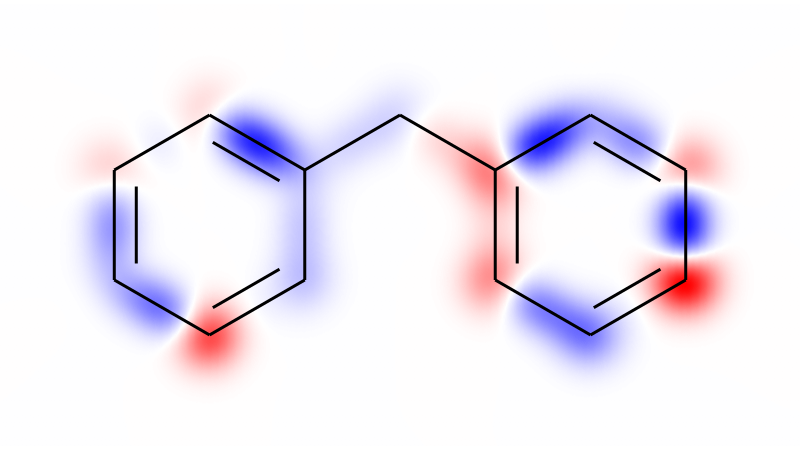

In [6]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights)
img = transform2png(canvas.GetDrawingText())
img

## Options
### Width and length of depicted Gauss-functions

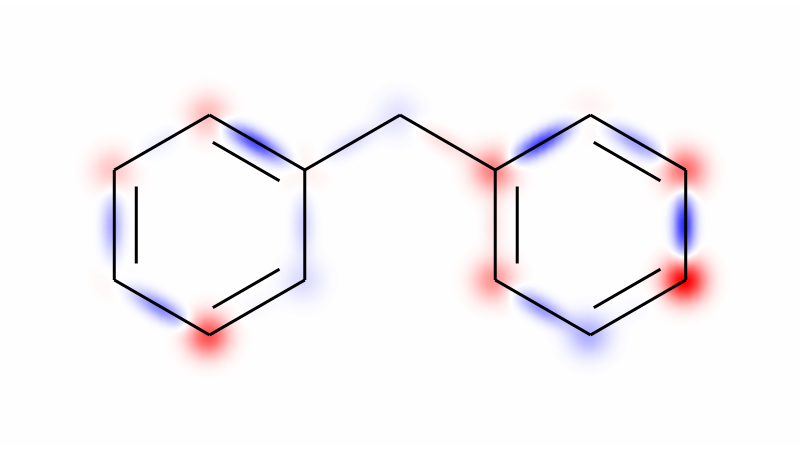

In [7]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, atom_width=0.2, bond_length=0.3, bond_width=0.1)
img = transform2png(canvas.GetDrawingText())
img

### Specifying colormap

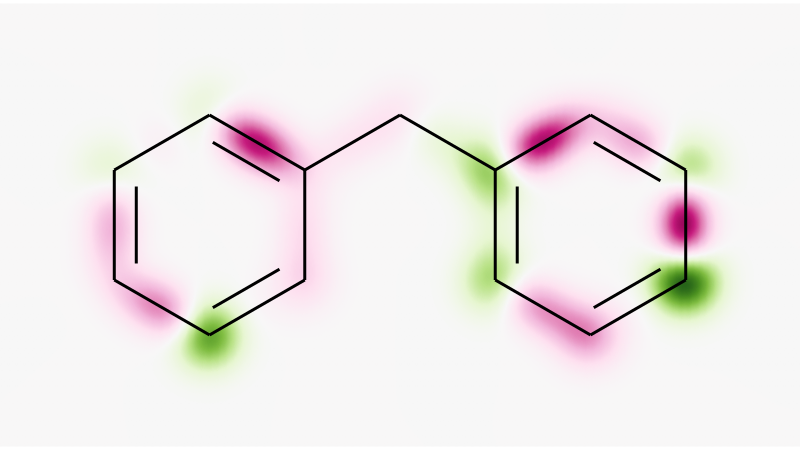

In [8]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, color="PiYG")
img = transform2png(canvas.GetDrawingText())
img

#### Using your own colormap

In [9]:
from matplotlib.colors import ListedColormap

# Definition of color
yellow = np.array([1, 1, 0, 1])
white  = np.array([1, 1, 1, 1])
purple = np.array([1, 0, 1, 1])

# Creating linear gradient for color mixing
linspace = np.linspace(0, 1, int(128))
linspace4d = np.vstack([linspace]*4).T

# interpolating values for 0 to 0.5 by mixing purple and white
zero_to_half = linspace4d * white + (1-linspace4d) * purple
# interpolating values for 0.5 to 1 by mixing white and yellow
half_to_one = yellow * linspace4d + white * (1-linspace4d)

# Creating new colormap from 
newcmp = ListedColormap(np.vstack([zero_to_half,half_to_one]))

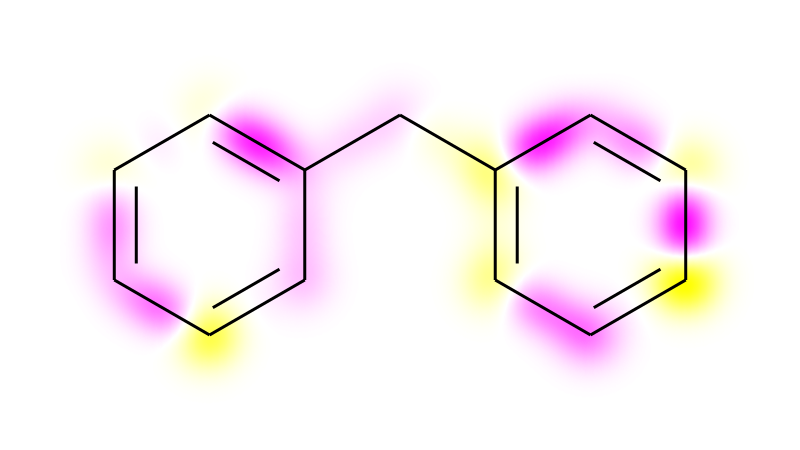

In [21]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, color=newcmp)
img = transform2png(canvas.GetDrawingText())
img

### Specifying boundaries of depicted values

In [11]:
max_value = np.max([np.max(atom_weights), np.max(bond_weights)])
min_value = np.min([np.min(atom_weights), np.min(bond_weights)])

In [12]:
print("Values range from {:0.2f} to {:0.2f}".format(min_value, max_value))

Values range from -0.66 to 0.84


In [13]:
artificial_limit = [-2, 2]

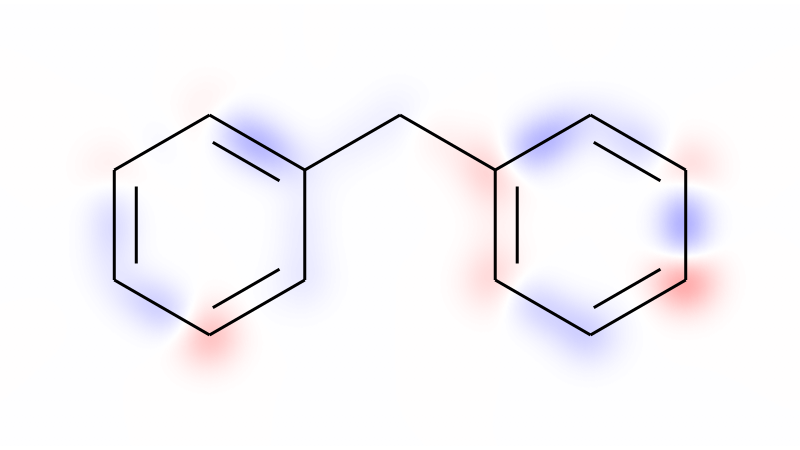

In [14]:
canvas = mapvalues2mol(test_mol, atom_weights, bond_weights, value_lims=artificial_limit)
img = transform2png(canvas.GetDrawingText())
img

### Miscellaneous options
* `canvas` (`rdMolDraw2D.MolDraw2D`): Rdkit Canvas to draw on. If none is given, a new one is created 
* `grid_resolution` (`[int, int]`): number of drawn pixels (x and y axis)
* `padding` (`[float, float]`): increase of height and width of heatmap relative to space of drawn molecule (usually increased by 100%)

## Function

## Other features of this package
### Mapping custom functions

### Drawing images

In [15]:
from rdkit.Chem import AllChem

from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DCairo
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions
from rdkit.Geometry.rdGeometry import Point2D
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
from rdkit_heatmaps import heatmaps
from rdkit_heatmaps.utils import get_mol_lims
from rdkit_heatmaps.utils import pad

from rdkit_heatmaps.functions import GaussFunction2D

In [18]:
image = np.array(Image.open('039.jpg'))
image = image / 255
image = np.flip(image, axis=0)
ones = np.ones([*image.shape[:2], 1])
image = np.append(image, ones, axis=2)
image = np.swapaxes(image,1,0)
s = 5
c_grid = heatmaps.ColorGrid([s,-s], [s/8*4.5,-s/8*4.5], image.shape[0], image.shape[1])
c_grid.color_grid = image

NameError: name 'Image' is not defined

In [ ]:
d = MolDraw2DCairo(800, 450)
do = d.drawOptions()
do.padding = 0.2
do.bondLineWidth = 3
d.SetDrawOptions(do)
d.DrawMolecule(test_mol)
heatmaps.color_canvas(d, c_grid)
d.DrawMolecule(test_mol)
transform2png(d.GetDrawingText())